# How to analyze a city mobility network and the relationship with nature ?

The city network will come from [OpenStreetMap](https://www.openstreetmap.org) also called OSM. Nature is coming from two sources: OSM have some green and blue areas that are tagged but they are usually "official" nature like parks or lakes, clear nature entities. The other source is the [European Space Agency World Cover](https://esa-worldcover.org) based on satellite images classified as nature or not depending on the pixel patterns.

The city will be chosen from the [Global Human Settlement Urban Center Database](https://ghsl.jrc.ec.europa.eu/ghs_stat_ucdb2015mt_r2019a.php) also called GHS UCDB.

Because the full workflow is using osmnx to extract the graph, we don't use shapely > 2.0 and dask-geopandas, making the process slower. We also don't use networkx > 3.0.

In [1]:
# OS
import os
import subprocess
# Profiling
from time import perf_counter
# Dataframe
import pandas as pd
import geopandas as gpd
# Analysis
from collections import Counter
# Geometry
import shapely
# Math
import numpy as np
# Network
import networkx as nx
# OpenStreetMap call
import osmnx as ox
# Custom network simplification
from nerds_osmnx.simplification import simplify_graph, multidigraph_to_graph
# Custom online PostgreSQL database functions
import atg
# Visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
# Merge dictionaries
def merge_dicts(dicts):
    """
    Merge a list of dictionaries as one. If a key is present in multiple
    dictionaries the values of multiple dictionaries are merged.
    """
    longest_dict_id = np.argmax([len(elem) for elem in dicts])
    new_dict = dicts[longest_dict_id]
    other_dict = dicts
    other_dict.pop(longest_dict_id)
    for d in other_dict:
        for key in d:
            if key in new_dict:
                for val in d[key]:
                    if val not in new_dict[key]:
                        new_dict[key].append(val)
            else:
                new_dict[key] = d[key]
    return new_dict

# Add a new edge attribute based on a boolean condition
def add_edge_attribute(G, attr_dict, name, bool_response=True):
    """
    Add an edge attribute where the value are binary bool based on
    whether the edge have a specific value for a given attribute,
    given as a dictionary.

    Parameters
    ----------
    G : networkx Graph/DiGraph/MultiGraph/MultiDiGraph/...
        Graph on which we want to add an attribute.
    attr_dict : dict
        Dictionary where the key are the key of the edges' attributes
        and values are the values of those attributes that we want to
        take into account.
    name : str
        Name of the new attribute.
    bool_response : bool, optional
        Bool response if we find one of the values on one of the
        attributes of the edges from the dictionary.
        The default is True.

    Raises
    ------
    NameError
        Raised if the name is already an attribute of an edge
        of the graph, in order to avoid unintended mix.

    Returns
    -------
    G : networkx Graph/DiGraph/MultiGraph/MultiDiGraph/...
        Graph with the new binary attribute.

    """
    G = G.copy()
    for edge in G.edges:
        if name in G.edges[edge]:
            raise NameError(
                "New attribute {} already in edge {}, use a new name".format(
                    name, edge)
                )
        for key in list(attr_dict.keys()):
            if key in list(G.edges[edge].keys()):
                if G.edges[edge][key] in attr_dict[key]:
                    G.edges[edge][name] = bool_response
                    break # otherwise next key can replace the value
                else:
                    G.edges[edge][name] = not bool_response
    return G

# Create new attributes for networks' edges related to the bikeability of the road.
def filter_bicycle_network(city=None, G=None, level=1, merge_level=False):
    """
    Add new attribute of bikeability based on OSM tags of the graph G,
    either given in the function or retrieved from the name of the city.
    """
    if level not in [1, 2, 3, 4]:
        raise ValueError("Level chosen not between 1 and 4.")
    if G is None and city is None:
        raise ValueError(
            "You have not specified a graph or the name of a city.")
    # Filters include bikeable roads
    prot_bnw = {
        'cycleway': ['track'],
        'cycleway:left': ['track'],
        'cycleway:right': ['track'],
        'cycleway:both': ['track'],
        'bicycle': ['designated'],
        'bicycle_road': ['yes'],
        'cyclestreet': ['yes'],
        'highway': ['cycleway', 'path']}
    unprot_bnw = {
        'cycleway': ['lane', 'opposite_lane', 'share_busway',
                     'shared_lane', 'designated' , 'yes'] ,
        'cycleway:left': ['lane', 'opposite_lane', 'share_busway',
                          'shared_lane', 'designated' , 'yes'] ,
        'cycleway:right': ['lane', 'opposite_lane', 'share_busway',
                           'shared_lane', 'designated' , 'yes'] ,
        'cycleway:both': ['lane', 'opposite_lane', 'share_busway',
                          'shared_lane', 'designated' , 'yes'] ,
        'bicycle': [ 'yes', 'permissive', 'destination' , 'private' ],
        'highway': ['living_street']}
    ext_bnw = {
        'highway': ['residential'],
        'maxspeed': ['5', '10', '15', '20', '30']}
    # Work in the opposite way: exclude not include bikeable roads
    leg_bnw = {'area': ['yes'],
               'highway': ['footway', 'steps', 'corridor', 'elevator',
                           'escalator', 'motor', 'proposed', 'construction',
                           'abandoned', 'platform', 'raceway', 'motorway',
                           'motorway_link', 'planned', 'proposed',
                           'bus_guideway'],
               'bicycle': ['no'],
               'service': ['private']}

    if G is None:
        for tag_name in list(['cycleway', 'cycleway:left', 'cycleway:right',
                              'cycleway:both', 'bicycle', 'bicycle_road',
                              'cyclestreet', 'highway', 'maxspeed', 'service',
                              'area']):
            if tag_name not in ox.settings.useful_tags_way:
                ox.settings.useful_tags_way += [tag_name]
        G = ox.graph_from_place(city, simplify=False)
    #TODO: Test if level 4 works
    if merge_level is False:
        for l, d in enumerate([prot_bnw, unprot_bnw, ext_bnw][:level]):
            G = add_edge_attribute(G, d, "level_{}".format(l+1))
        if level == 4:
            G = add_edge_attribute(G, leg_bnw, "level_4", bool_response=False)
    else:
        if level == 1:
            G = add_edge_attribute(G, prot_bnw, "level_1")
        elif level == 4:
            merged_dict = merge_dicts([prot_bnw, unprot_bnw, ext_bnw])
            G = add_edge_attribute(G, merged_dict, "level_1-3")
            G = add_edge_attribute(G, leg_bnw, "level_4", bool_response=False)
            G = add_edge_attribute(G, {'level_1-3':[True], 'level_4':[True]},
                                   'level_1-4')
            for e in G.edges:
                for attr in ['level_1-3', 'level_4']:
                    G.edges[e].pop(attr)
        else:
            merged_dict = merge_dicts([prot_bnw, unprot_bnw, ext_bnw][:level])
            G = add_edge_attribute(G, merged_dict, "level_1-{}".format(level))
    return G

# Create a point at a specific distance of another point
def create_additional_point(fp, lp, dist):
    """
    Create a new point that is at a specific distance of the first point fp,
    on the same line as fp and lp.
    """
    fp = np.array(fp)
    lp = np.array(lp)
    uv = (fp - lp)/np.linalg.norm(fp - lp) # unit vector between fp and vp
    newp = fp - uv*dist
    return newp

# Divide a LineString into smaller Linestrings of even size
def threshold_edge_size(tested_edge, max_length=20, verbose=False):
    """Divide a LineString into multiple smaller LineString of even size such
    as every LineString is smaller than the max_length"""
    old_edge = tested_edge
    # if > than the max_length, divide it into smaller even pieces
    if old_edge.length > max_length:
        new_edges = []
        # if exact multiple, no need to add 1 to the integer division
        if old_edge.length%max_length != 0:
            number_div = old_edge.length // max_length + 1
        else:
            number_div = old_edge.length // max_length
        edge_size = old_edge.length / number_div
        if verbose is True: # debug option
            print("Number of new edges = ", number_div,
                  "edges of length", edge_size)
        # number of coordinates of the LineString for the new edge
        npoint = 2 
        while len(new_edges) < number_div:
            # Add coord until edge > edge_size, then cut to exact value
            # by creating a new coord
            if shapely.geometry.LineString(
                    old_edge.coords[:npoint]).length > edge_size:
                # need to separate because we can't have an empty LineString
                if npoint > 2:
                    new_point = create_additional_point(
                        old_edge.coords[npoint-2], old_edge.coords[npoint-1],
                        edge_size - shapely.geometry.LineString(
                            old_edge.coords[:npoint-1]).length)
                else:
                    new_point = create_additional_point(
                        old_edge.coords[0], old_edge.coords[1],
                        edge_size)
                new_coords = old_edge.coords[:npoint-1]
                new_coords.append(new_point)
                new_edges.append(shapely.geometry.LineString(new_coords))
                updated_old_coords = old_edge.coords[npoint-1:]
                updated_old_coords.insert(0, new_point)
                old_edge = shapely.geometry.LineString(updated_old_coords)
                npoint = 2
            elif len(old_edge.coords[:]) == npoint:
                new_edges.append(old_edge)
            else:
                npoint += 1
        return new_edges
    else:
        return old_edge

# Divide every edges in even edges of an arbitrary maximum length.
def divide_evenly_edges(G, max_length=20):
    # Node dataframe
    u, data = zip(*G.nodes(data=True))
    gdf_nodes = gpd.GeoDataFrame(data)
    node_stored = []
    edge_stored = []
    edge_removed = []
    number = max(G)
    for edge in G.edges:
        # Create a list of LineString if edge's length > max_length
        saved_edges = threshold_edge_size(G.edges[edge]['geometry'], max_length=max_length, verbose=False)
        if isinstance(saved_edges, list):
            # Store every edge attribute for every new edge except geometry and length
            edge_attr_dict = G.edges[edge].copy()
            edge_attr_dict.pop('geometry')
            edge_attr_dict.pop('length')
            # Remove old long edge
            edge_removed.append(edge)
            f_coord = G.edges[edge]['geometry'].coords[0]
            # Find the node which is the first coordinate of the edge geometry
            bef = gdf_nodes[(gdf_nodes['x']==f_coord[0]) & (gdf_nodes['y']==f_coord[1])].index[0]
            first = bef
            for e in saved_edges[:-1]:
                # Add new node with unique ID
                number += 1
                node_stored.append([number,
                        {'x':e.coords[-1][0], 'y':e.coords[-1][1]}])
                # Add specific geometry and length to the edge's attribute dictionary
                temp_dict = edge_attr_dict.copy()
                temp_dict['length'] = e.length
                temp_dict['geometry'] = e
                edge_stored.append([bef, number, temp_dict])
                bef = number
            temp_dict = edge_attr_dict.copy()
            temp_dict['geometry'] = saved_edges[-1]
            temp_dict['length'] = saved_edges[-1].length
            if first == edge[0]:
                last = edge[1]
            elif first == edge[1]:
                last = edge[0]
            edge_stored.append([bef, last, temp_dict])
        else:
            pass
    H = G.copy()
    H.add_nodes_from(node_stored)
    H.remove_edges_from(edge_removed)
    H.add_edges_from(edge_stored)
    for edge in H.edges:
        # Not a new edge but an old edge without the right edge's length
        if H.edges[edge]['length'] > max_length and edge in G.edges:
            print("""Miscalculation for edge {},
                show length as {} while it is {}""".format(
                edge, H.edges[edge]['length'], H.edges[edge]['geometry'].length))
            H.edges[edge]['length'] = H.edges[edge]['geometry'].length
        else:
            pass
    return H

# Find relationship between road network and nature.
def graph_nature_relationship(G, nature, buff_size=20, inside_threshold=40, mode="ground"):
    u, v, data = zip(*G.edges(data=True))
    gdf_edges = gpd.GeoDataFrame(data)
    gdf_edges.set_geometry("geometry", inplace=True)
    gdf_edges.crs = G.graph['crs']
    gdf_edges["edge"] = list(zip(u, v))
    gdf_edges.set_index("edge", inplace=True)
    gdf_edges_buff = gdf_edges.copy()
    gdf_edges_buff['geometry'] = gdf_edges_buff.geometry.buffer(buff_size, cap_style=2, join_style=3)
    # Buffer and do sjoin instead of sjoin_nearest to change cap style and join style of the buffer zone
    edge_sjoin = gpd.sjoin(gdf_edges_buff, nature, how='left')
    # Sort for faster search
    edge_sjoin = edge_sjoin.sort_index()
    # First filter all edges without close nature and tag them as isolated
    iso = list(edge_sjoin[edge_sjoin['index_right'].isnull()].index)
    # Aggregate to get list of close nature ID
    nat_nearby = edge_sjoin.groupby("edge")['index_right'].apply(lambda x: list(x))
    # Remove them of the geodataframe
    edge_nature = nat_nearby.copy().drop(iso)
    nat_nearby = dict(nat_nearby)
    # Then filter all edges with only one close polygon
    one_poly = edge_nature[edge_nature.apply(lambda x: True if len(x)==1 else False)].apply(lambda x: x[0])
    mul_poly = edge_nature.drop(one_poly.index)
    # Create MultiPolygon
    mp_geom = gpd.GeoSeries(data=mul_poly.apply(lambda x: shapely.ops.unary_union(nature.geometry[x].values)), index=mul_poly.index, crs=G.graph['crs'])
    op_geom = gpd.GeoSeries(data=nature.geometry[one_poly.values].values, index=one_poly.index, crs=G.graph['crs'])
    # Merge and test every cases the same way
    ap_geom = pd.concat([op_geom, mp_geom])
    size_ha = dict(ap_geom.geometry.area / 10000)
    for edge in iso:
        size_ha[edge] = 0
    # Outside of relationship with edge find nature nearby and size of nature
    nat_nearby = edge_nature.copy()
    # Test for intersection
    ap_inter_length = 100 * gdf_edges.geometry[ap_geom.index].intersection(ap_geom, align=False).length / gdf_edges.geometry[ap_geom.index].length
    # Remove on with 0 intersection length, less than 40% of the length are inbetween, more are inside
    wo_inter = ap_inter_length[ap_inter_length.apply(lambda x: True if x==0 else False)].index
    w_inter = ap_inter_length.drop(wo_inter)
    inbet = list(w_inter[w_inter.apply(lambda x: True if x<=inside_threshold else False)].index)
    inside = list(w_inter.drop(inbet).index)
    if mode == "ground":
        # The ones without intersection are tested for surrounded, if not then alongside
        pos_buff = gdf_edges.geometry[wo_inter].buffer(buff_size, cap_style=2, join_style=3, single_sided=True)
        neg_buff = gdf_edges.geometry[wo_inter].buffer(-buff_size, cap_style=2, join_style=3, single_sided=True)
        # Surrounded if both positive and negative buffer intersect with the polygons
        pos_inter = pos_buff.geometry.intersects(ap_geom.geometry[wo_inter], align=False)
        neg_inter = neg_buff.geometry.intersects(ap_geom.geometry[wo_inter], align=False)
        surr = list(wo_inter[pos_inter & neg_inter])
        along = list(wo_inter.drop(surr))
        # Get every edges and create a dict of status
        # TODO: Really fast so don't care for computation but ugly
        stat_dict = dict()
        st_res = ['isolated', 'alongside', 'surrounded', 'inbetween', 'inside']
        for num, st in enumerate([iso, along, surr, inbet, inside]):
            choice = st_res[num]
            for ind in st:
                stat_dict[ind] = choice
        return nat_nearby, size_ha, stat_dict
    elif mode == "cover":
        iso += list(wo_inter)
        cov_dict = dict()
        st_res = ['none', 'partial', 'full']
        for num, st in enumerate([iso, inbet, inside]):
            choice = st_res[num]
            for ind in st:
                cov_dict[ind] = choice
        return nat_nearby, cov_dict


Because the full workflow is hours long, we save intermediate results in a directory.

In [3]:
resdir = "./results/"
if not os.path.exists(resdir):
    os.makedirs(resdir)

## Download and curate the city network

In [4]:
city = 'Turin'
country = 'Italy'

We extract the city network from OpenStreetMap with [Osmnx](https://osmnx.readthedocs.io/en/stable/). We add the tags related to cycling to the extraction. The function osmnx.graph_from_place() is automatically finding the administrative boundaries of the city, but we better need to specify the country to avoid confusion between cities with the same name, and it's not always working as OSM can be inconsistent (for instance with Athens, Copenhagen, Glasgow...), so we need to make sure to get a network, and that the network is corresponding to the actual city.

The network object will be a [NetworkX](https://networkx.org/documentation/stable/index.html) MultiDiGraph.

In [5]:
for tag_name in list([
    'cycleway', 'cycleway:left', 'cycleway:right',
    'cycleway:both', 'bicycle', 'bicycle_road',
    'cyclestreet', 'highway', 'maxspeed', 'service', 'area']):
    if tag_name not in ox.settings.useful_tags_way:
        ox.settings.useful_tags_way += [tag_name]
try:
    G = ox.graph_from_place(city + ', ' + country, simplify=False)
except:
    print(f"No graph found for {city}, {country} in OSM !")

Once we have the network, we can curate it. First we create a bikeability attribute that can tell us how bikeable a road is. Then we want to reduce the size of the network as much as possible so we simplify it and remove edges on both ways by changing the type from a multidigraph to a graph. Finally we divide the edges so that most edges have roughly the same length. We need to have a consistent and small length across all edges so we can have some coherent granularity in the relationship between the edges and nature.

The longest execution is from the divide_evenly_edges. The bigger the network, the longer it is. We'll time the longest functions using time.perf_counter().

In [6]:
G = filter_bicycle_network(G=G, level=4, merge_level=False)
# Simplify 4 boolean attributes to one with 5 values
for edge in G.edges:
    if G.edges[edge]['level_1'] == True:
        G.edges[edge]['bikeability_level'] = 1
    elif G.edges[edge]['level_2'] == True:
        G.edges[edge]['bikeability_level'] = 2
    elif G.edges[edge]['level_3'] == True:
        G.edges[edge]['bikeability_level'] = 3
    elif G.edges[edge]['level_4'] == True:
        G.edges[edge]['bikeability_level'] = 4
    else:
        G.edges[edge]['bikeability_level'] = 5
print(f"Number of edges before simplification: {len(G.edges)}")
# We simplify the edges after adding the bikeability attribute to keep discriminating them
# We need to simplify to reduce as much as we can the number of nodes
start = perf_counter()
G = simplify_graph(G, attributes=['bikeability_level'])
# Project to make a threshold in meters on edges' length
G = ox.project_graph(G, to_crs=None)
# Reduce size of the graph
G = multidigraph_to_graph(G, attributes=['bikeability_level'])
end = perf_counter()
print(f"Execution time to simplify network: {end - start}s")
print(f"Number of edges after simplification: {len(G.edges)}")
# Relabel as the nodes' ID are meaningless and easier to add new nodes with unique ID
G_relab = nx.convert_node_labels_to_integers(G)
for e in G_relab.edges:
    G_relab.edges[e]['length'] = G_relab.edges[e]['geometry'].length
start = perf_counter()
# Divide edges evenly so most of them make the same small size
G= divide_evenly_edges(G_relab, max_length=20)
end = perf_counter()
nx.write_gpickle(G, resdir + f"{city}_{country}_graph.gpickle")
print(f"Execution time to divide edges: {end - start}s")
print(f"Number of edges after division of edges: {len(G.edges)}")

Number of edges before simplification: 198547
Execution time to simplify network: 72.72626059999993s
Number of edges after simplification: 52747
Execution time to divide edges: 70.68379289999984s
Number of edges after division of edges: 169082


In [7]:
# G = nx.read_gpickle(resdir + f"{city}_{country}_graph.gpickle")

## Download nature from the online database

The online database is in [PostgreSQL](https://www.postgresql.org/). We will acces to the database by first creating a [SSH tunnel](https://en.wikipedia.org/wiki/Tunneling_protocol#Secure_Shell_tunneling) to connect to the database with the package from the Python Standard Library [Subprocess](https://docs.python.org/3/library/subprocess.html). Then we will use PostgreSQL commands using [Psycopg](https://www.psycopg.org/).

In [8]:
# Create SSH tunnel to behave like the online database is locally hosted
ssh_tunnel =  subprocess.Popen("ssh -CNL localhost:5433:localhost:5432 sclement@130.192.212.149")
# Specify database parameters
db_params = {'db_user':"ubuntu", 'db_password':"ubuntu", 'db_host':"localhost", 'db_port':"5433", 'db_name':"esa"}

Custom functions made by Alice Battiston to work with the database are in the Atg package. The results will be stored in a GeoDataFrame object from the [GeoPandas](https://geopandas.org/en/stable/), an adaptation of the [Pandas](https://pandas.pydata.org/) package to handle [Shapely](https://shapely.readthedocs.io/en/stable/) geometric object.

In [9]:
batch = []
start = perf_counter()
# Get the ESA polygons for each defined code
for code in [10, 20, 30, 40, 80, 90, 95, 100]:
    res = atg.query4esa2polygons(city, [code], db_params)
    res['code'] = code
    res.set_crs(crs="epsg:4326", inplace=True, allow_override=True)
    batch.append(res)
# Index is useless here but used in the graph_relationship() function, so I need to make sure indexes are unique
esa = pd.concat(batch, ignore_index=True)
end = perf_counter()
print(f"Execution time to retrieve ESA nature: {end - start}s")
start = perf_counter()
# Get the OSM green areas
green = atg.query4osm2polygons(city, 'category', ['parks', 'forests', 'grass'], db_params)
green['type'] = 'green'
green.set_crs(crs="epsg:4326", inplace=True, allow_override=True)
# Get the OSM blue areas
blue = atg.query4osm2polygons(city, 'category', ['river', 'lake'], db_params)
blue['type'] = 'blue'
blue.set_crs(crs="epsg:4326", inplace=True, allow_override=True)
osm = pd.concat([green, blue], ignore_index=True)
end = perf_counter()
print(f"Execution time to retrieve OSM nature: {end - start}s")
esa.to_file(resdir + f"{city}_{country}_esa.geojson", driver='GeoJSON')
osm.to_file(resdir + f"{city}_{country}_osm.geojson", driver="GeoJSON")

Execution time to retrieve ESA nature: 39.63285480000013s
Execution time to retrieve OSM nature: 3.3777556000000004s


In [10]:
ssh_tunnel.terminate()

In [11]:
# esa = gpd.read_file(resdir + f"{city}_{country}_esa.geojson")
# osm = gpd.read_file(resdir + f"{city}_{country}_osm.geojson")

## Filter nature

The nature we downloaded from the database is based on the boundaries of the GHS UCDB definition of each cities, which are not administrative boundaries but boundaries based on degree of urbanization. It can be smaller or larger than the adminsitrative boundaries of the OSM graph, so we need to constraint it to the OSM boundaries. We also make a difference between "ground" nature and "cover" nature: both can make the experience nicer. But while coverage can be useful to have shades during your trip, it can also be a concrete road with trees arounds which is a different experience than to be inside or near nature.

In [12]:
# Remove chained assignment warning
pd.options.mode.chained_assignment = None
buff_size = 20
# Tree canopy is code 10 so every other code is ground nature
ground_esa = esa[esa['code'].isin([20, 30, 40, 80, 90, 95, 100])]
# Separate between ESA green and blue areas
ground_esa['type'] = ground_esa['code'].apply(
    lambda x: 'blue' if x in [80, 90, 95, 100] else 'green').values
# OSM nature is always ground nature
ground_nat = pd.concat([ground_esa, osm], ignore_index=True)
cover_nat = esa[esa['code'] == 10]
# Project nature to local crs
ground_nat.to_crs(crs=G.graph['crs'], inplace=True)
cover_nat.to_crs(crs=G.graph['crs'], inplace=True)
# Find network boundaries as a buffed bounding box
u, v, data = zip(*G.edges(data=True))
gdf_edges = gpd.GeoDataFrame(data)
gdf_edges.set_geometry("geometry", inplace=True)
bounds = gdf_edges.bounds
xmin = min(bounds['minx'])
ymin = min(bounds['miny'])
xmax = max(bounds['maxx'])
ymax = max(bounds['maxy'])
start = perf_counter()
ground_nat = ground_nat.cx[
    xmin - 2*buff_size : xmax + 2*buff_size,
    ymin - 2*buff_size : ymax + 2*buff_size]
# Merge separately blue and green areas for ESA and OSM nature
blue_ground_nat = ground_nat[ground_nat['type'] == 'blue']
green_ground_nat = ground_nat[ground_nat['type'] == 'green']
blue_merged = gpd.GeoDataFrame(
    geometry=[poly for poly in blue_ground_nat.unary_union.geoms], crs=G.graph['crs'])
blue_merged['type'] = 'blue'
green_merged = gpd.GeoDataFrame(
    geometry=[poly for poly in green_ground_nat.unary_union.geoms], crs=G.graph['crs'])
green_merged['type'] = 'green'
ground_nat = pd.concat([green_merged, blue_merged], ignore_index=True)
end = perf_counter()
print(f"Execution time to filter ground nature: {end - start}s")
ground_nat['size_ha'] = ground_nat.geometry.area / 10000
start = perf_counter()
cover_nat = cover_nat.cx[
    xmin - 2*buff_size : xmax + 2*buff_size,
    ymin - 2*buff_size : ymax + 2*buff_size]
cover_nat = gpd.GeoDataFrame(
    geometry=[poly for poly in cover_nat.unary_union.geoms], crs=G.graph['crs'])
end = perf_counter()
print(f"Execution time to filter cover nature: {end - start}s")
# Coverage is always green nature
cover_nat['type'] = 'green'
cover_nat['size_ha'] = cover_nat.geometry.area / 10000

# Local crs impossible to save in geojson file, so we reproject to global epsg and project back when we load the data
ground_nat_save = ground_nat.to_crs(crs="epsg:4326")
cover_nat_save = cover_nat.to_crs(crs="epsg:4326")
ground_nat_save.to_file(resdir + f"{city}_{country}_ground.geojson", driver='GeoJSON')
cover_nat_save.to_file(resdir + f"{city}_{country}_cover.geojson", driver='GeoJSON')

Execution time to filter ground nature: 6.344279599999936s
Execution time to filter cover nature: 7.751161200000297s


In [13]:
# ground_nat = gpd.read_file(resdir + f"{city}_{country}_ground.geojson")
# cover_nat = gpd.read_file(resdir + f"{city}_{country}_cover.geojson")
# ground_nat.to_crs(crs=G.graph['crs'], inplace=True)
# cover_nat.to_crs(crs=G.graph['crs'], inplace=True)

## Find relationship between the road network and nature

In [14]:
start = perf_counter()
ground_nat_nearby, cover_nat_nearby, size_ha, stat_dict, cov_dict = find_graph_nature_relationship(
    G, ground_nat, cover_nat, buff_size=20, inside_threshold=40)
end = perf_counter()
print(f"Execution time to find relationship with nature: {end - start}s")
nx.set_edge_attributes(G, ground_nat_nearby, "ground_nat_nearby")
nx.set_edge_attributes(G, cover_nat_nearby, "cover_nat_nearby")
nx.set_edge_attributes(G, size_ha, "size_ha")
nx.set_edge_attributes(G, stat_dict, "status")
nx.set_edge_attributes(G, cov_dict, "coverage")
nx.write_gpickle(G, resdir + f"{city}_{country}_graph_res.gpickle")

Execution time to find relationship with ground nature: 353.6077961000001s
Execution time to find relationship with cover nature: 778.1489704999999s


In [15]:
# G = nx.read_gpickle(resdir + f"{city}_{country}_graph_res.gpickle")

## Visualize the results

In [16]:
# Create GeoDataFrame
u, v, data = zip(*G.edges(data=True))
gdf_edges = gpd.GeoDataFrame(data)
gdf_edges.set_geometry("geometry")
gdf_edges.crs = G.graph['crs']
# Get the right order for colormaps
gdf_edges['status'] = pd.Categorical(gdf_edges['status'], ['isolated', 'alongside', 'inbetween', 'surrounded', 'inside'])
gdf_edges['coverage'] = pd.Categorical(gdf_edges['coverage'], ['none', 'partial', 'full'])

In [17]:
c_ground = Counter(gdf_edges['status'])
print(f"""
    {round(100*c_ground['isolated']/len(gdf_edges), 2)}% are isolated,
    {round(100*c_ground['alongside']/len(gdf_edges), 2)}% alongside,
    {round(100*c_ground['surrounded']/len(gdf_edges), 2)}% surrounded,
    {round(100*c_ground['inbetween']/len(gdf_edges), 2)}% inbetween
    and {round(100*c_ground['inside']/len(gdf_edges), 2)}% inside.
    """)

c_cover = Counter(gdf_edges['coverage'])
print(f"""
    {round(100*c_cover['none']/len(gdf_edges), 2)}% are not covered,
    {round(100*c_cover['partial']/len(gdf_edges), 2)}% are partially covered,
    {round(100*c_cover['full']/len(gdf_edges), 2)}% are fully covered.
    """)

c_bike = Counter(gdf_edges['bikeability_level'])
print(f"""
    {round(100*c_bike[1]/len(gdf_edges), 2)}% are at level 1,
    {round(100*c_bike[2]/len(gdf_edges), 2)}% level 2,
    {round(100*c_bike[3]/len(gdf_edges), 2)}% level 3,
    {round(100*c_bike[4]/len(gdf_edges), 2)}% level 4
    and {round(100*c_bike[5]/len(gdf_edges), 2)}% level 5.
    """)


    62.65% are isolated,
    17.35% alongside,
    3.92% surrounded,
    1.95% inbetween
    and 14.12% inside.
    

    68.12% are not covered,
    5.46% are partially covered,
    26.42% are fully covered.
    

    9.4% are at level 1,
    4.74% level 2,
    35.6% level 3,
    35.37% level 4
    and 14.88% level 5.
    


Text(0.5, 1.0, 'Relationship to cover nature')

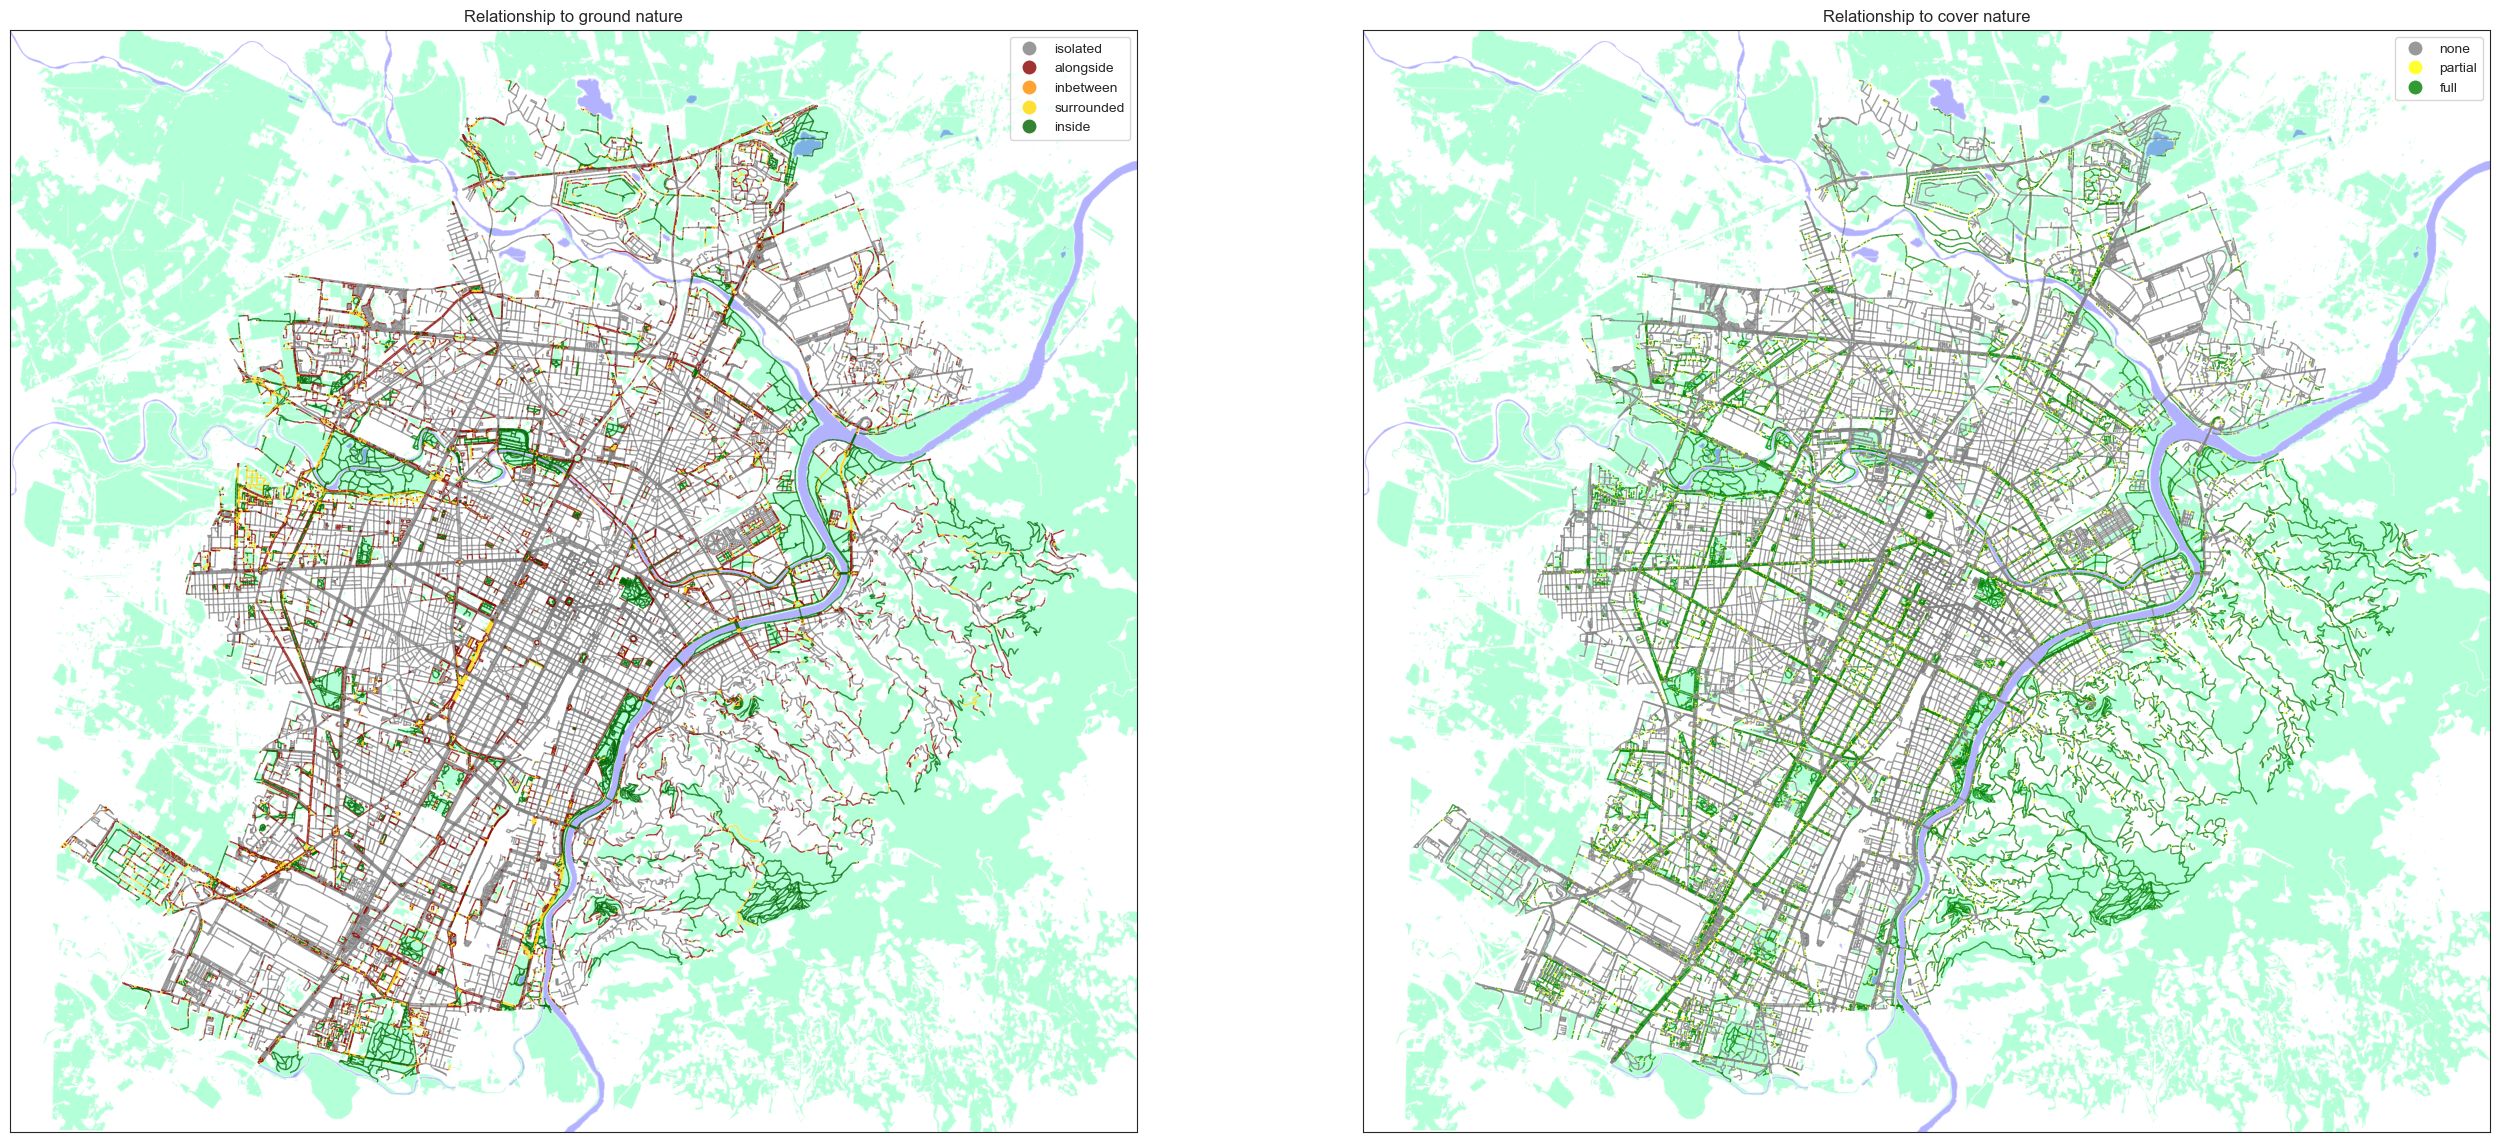

In [18]:
sns.set_style('white')
fig, axs = plt.subplots(1, 2, figsize=(32, 18))

ax = axs[0]
custom_cmap = mpl.colors.ListedColormap(["gray", "darkred", "darkorange", "gold", "darkgreen"])
gdf_edges.plot(column='status', alpha=0.8, linewidth=1, ax=ax, cmap=custom_cmap, legend=True)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ground_nat.plot(column='type', alpha=0.3, ax=ax, cmap='winter')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Relationship to ground nature")

ax = axs[1]
custom_cmap = mpl.colors.ListedColormap(["grey", "yellow", "green"])
gdf_edges.plot(column='coverage', alpha=0.8, linewidth=1, ax=ax, cmap=custom_cmap, legend=True)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ground_nat.plot(column='type', alpha=0.3, ax=ax, cmap='winter')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Relationship to cover nature")

Text(0.5, 1.0, 'Bikeability level')

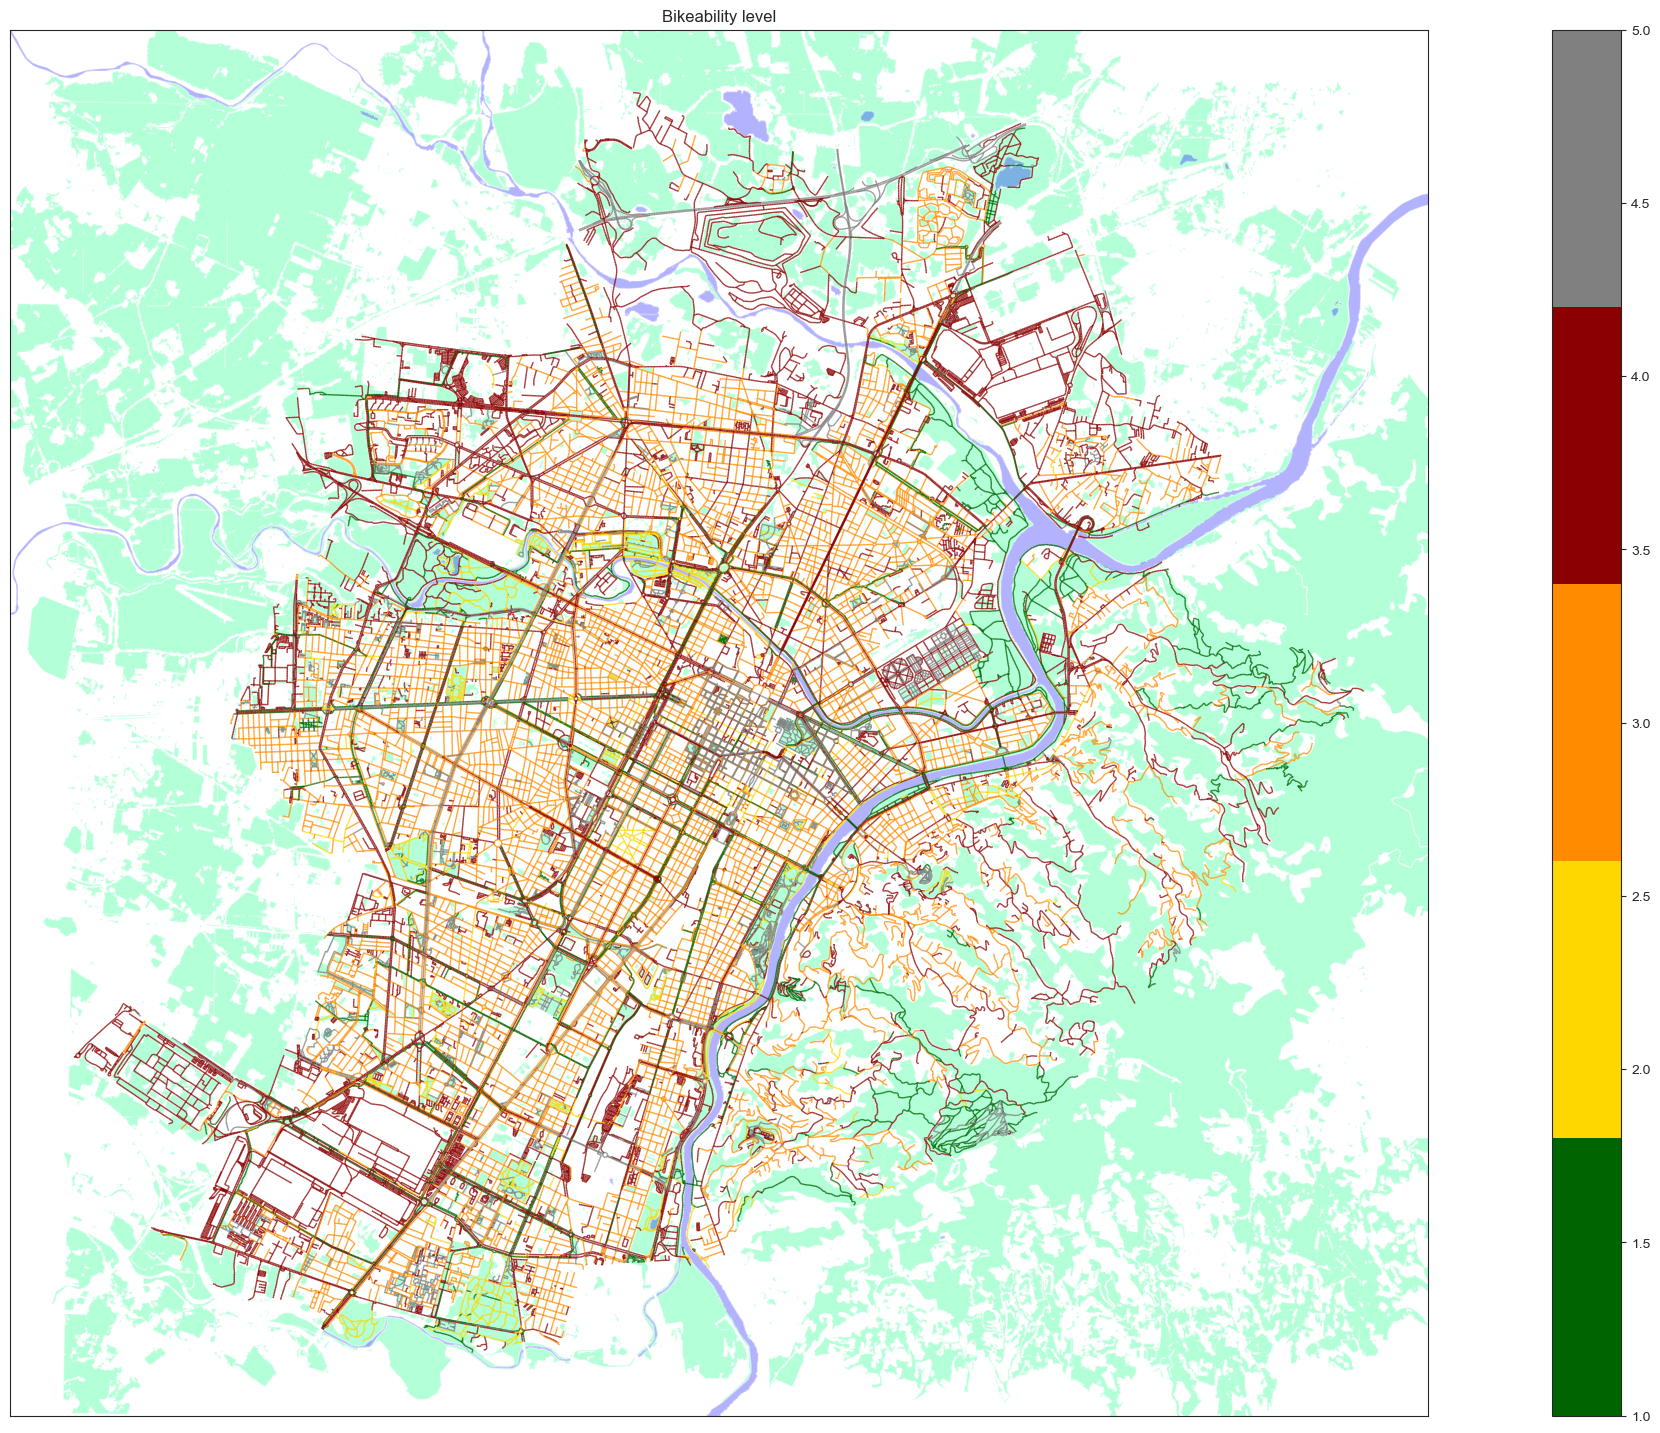

In [19]:
fig, ax = plt.subplots(figsize=(32, 18))
custom_cmap = mpl.colors.ListedColormap(["darkgreen", "gold", "darkorange", "darkred", "gray"])
gdf_edges.plot(column='bikeability_level', alpha=0.8, linewidth=1, ax=ax, cmap=custom_cmap, legend=True)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ground_nat.plot(column='type', alpha=0.3, ax=ax, cmap='winter')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Bikeability level")